<img src="https://habrastorage.org/files/063/6d1/1af/0636d11afa654531b08986cc3ff1b4ca.png" align='right'> Здравствуй, Хабр! 

Цикл статей по инструментам для обучения нейронных сетей продолжается обзором популярного фреймворка Tensorflow.

Tensorflow (далее - TF) - довольно молодой фреймворк для глубокого машинного обучения, разрабатываемый в Google Brain. Долгое время фреймворк разрабатывался в закрытом режиме под названием DistBelief, но после глобального рефакторинга 9 ноября 2015 года был выпущен в open source. За год с небольшим TF дорос до версии 1.0, обрел интеграцию с keras, стал значительно быстрее и получил поддержку мобильных платформ. В последнее время фреймворк развивается еще и в сторону классических методов, и в некоторых частях интерфейса уже чем-то напоминает scikit-learn. До текущей версии интерфейс менялся активно и часто, но разработчики пообещали заморозить изменения в API. Мы будем рассматривать только Python API, хотя это не единственный вариант - также существуют интерфейсы для C++ и мобильных платформ.
 <habracut/>

## Установка

TF устанавливается стандартно через python pip. Есть нюанс: существуют отдельные алгоритмы установки для работы на CPU и на видеокартах.  

В случае с CPU всё просто: нужно поставить из pip пакет под названием tensorflow.

Во втором случае нужно:
1. проверить совместимость с видеокартой. Параметр CUDA Compute Capability должен быть больше 3.0, найти его для своей видеокарты можно [тут](https://developer.nvidia.com/cuda-gpus)
2. Установить [CUDA Toolkit](https://developer.nvidia.com/cuda-downloads) восьмой версии
3. Установить [cuDNN](https://developer.nvidia.com/cudnn) версии 5.1
4. Установить из pip пакет tensorflow-gpu

Впрочем, документация утверждает, что поддерживаются и более ранние версии CUDA Toolkit и cuDNN, но рекомендует устанавливать версии, указанные выше.

Разработчики рекомендуют устанавливать TF в отдельную среду с virtualenv, чтобы избежать возможные проблемы с версионированием и зависимостями.

Еще один вариант установки - Docker. По умолчанию из контейнера будет работать только CPU-версия, но если использовать специальный [nvidia docker](https://github.com/NVIDIA/nvidia-docker), то можно использовать и GPU.

Сам я не пробовал, но говорят, что TF работает даже с Windows. Установка проводится через тот же pip и, говорят, работает без проблем.  

Я пропускаю процесс сборки из исходников, однако и такой вариант может иметь смысл. Дело в том, что пакет из репозитория собирается без поддержки SSE и прочих плюшек. В последних версиях TF проверяет наличие таких плюшек и сообщает, что из исходников он будет работать быстрее.

Подробно процесс установки описан [тут](https://www.tensorflow.org/install/).



## Документация

Документации и примеров очень много.
* [Официальный сайт](https://www.tensorflow.org)
* [Официальные туториалы](https://www.tensorflow.org/get_started/get_started)
* [Awesome-list - подборка всего самого наилучшего по теме](https://github.com/jtoy/awesome-tensorflow)
* [Отличный сборник разных моделей на TF](https://github.com/tensorflow/models/)

Лучше всего ориентироваться на официальную документацию - из-за быстрого развития и частой смены api, в интернете очень много туториалов и скриптов, которые ориентированы на старые версии (ну как старые... полугодовой давности) со старым API, они не будут работать с последними версиями фреймворка.

## Базовые элементы TF

С помощью «Hello, world» убедимся, что всё установилось правильно:

In [1]:
import tensorflow as tf # подключаем TF
hello = tf.constant('Hello, TensorFlow!') # создаем объект из TF
sess = tf.InteractiveSession() # создаем сессию
print(sess.run(hello)) #сессия "выполняет" объект

b'Hello, TensorFlow!'


Первой же строчкой подключаем TF. Уже сложилось правило вводить для фреймворка соответствующее сокращение. Этот же кусочек кода встречается в документации и позволяет удостовериться в том, что всё установилось правильно.

### Граф вычислений

Работа c TF строится вокруг построения и выполнения графа вычислений. Граф вычислений - это конструкция, которая описывает то, каким образом будут проводиться вычисления. В классическом императивном программировании мы пишем код, который выполняется построчно. В TF привычный императивный подход к программированию необходим только для каких-то вспомогательных целей. Основа TF - это создание структуры, задающей порядок вычислений. Программы естественным образом структурируются на две части - составление графа вычислений и выполнение вычислений в созданных структурах.  

Граф вычислений в TF по смыслу не отличается от такового в Theano. В [предыдущей статье](https://habrahabr.ru/company/ods/blog/323272/#predislovie-ili-liricheskoe-otstuplenie-o-bibliotekah-dlya-glubokogo-obucheniya) цикла дано отличное описание этой сущности. 

В TF граф состоит из плейсхолдеров, переменных и операций. Из этих элементов можно собрать граф, в котором будут вычисляться тензоры. Тензоры - многомерные массивы, они служат «топливом» для графа. Тензором может быть как отдельное число, вектор признаков из решаемой задачи или изображение, так и целый батч описаний объектов или массив из изображений. Вместо одного объекта мы можем передать в граф массив объектов и для него будет вычислен массив ответов. Работа TF с тензорами похожа на то, как обрабатывает массивы numpy, в функциях которого можно указать ось массива, относительно которой будет выполняться вычисление.

### Сессии

Вычислительные графы выполняются в сессиях. Объект сессии (`tf.Session`) скрывает в себе контекст выполнения графа - необходимые ресурсы, вспомогательные классы, адресные пространства.
Существует два типа сессий - обычные, которые реализованы в [tf.Session](https://www.tensorflow.org/api_docs/python/tf/Session) и интерактивные ([tf.InteractiveSession](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)). Разница между ними в том, что интерактивная сессия больше подходит для выполнения в консоли и сразу определяет себя как сессия по умолчанию. Основной эффект - объект сессии не нужно передавать в функции вычисления как параметр. В примерах далее я буду считать, что в данный момент работает интерактивная сессия, которую мы объявили в первом примере, и когда понадобится обращение к сессии, буду обращаться к объекту ```sess```.

Далее в посте будут появляться стандартные для TF картинки с изображениями графов, сгенерированные встроенной утилитой под названием Tensorboard. Обозначения там вот такие:

<table>
<tr>
<th>Переменная</th>
<th>Операция</th>
<th>Вспомогательный результат</th>
</tr>
<tr>

<td>Узел графа обычно содержит данные.</td>
<td>Делает что-то с переменными. Сюда же относятся плейсхолдеры, которые делают подстановку значений в граф.</td>
<td>Всякое кэширование и побочные вычисления типа градиентов, обычно так обозначают ссылку на отдельную часть графа.</td>
</tr>
<tr>
<td>
<img src="https://habrastorage.org/files/720/db6/88e/720db688e60042b59a8d68204421c401.png"/>
</td>
<td>
<img src="https://habrastorage.org/files/191/4b2/a19/1914b2a19b6d431d889ecbe96c66d891.png"/>
</td>
<td>
<img src="https://habrastorage.org/files/145/d34/cb7/145d34cb71d242759b0afaa4e10772b7.png"/>
</td>
</tr>
</table>



### Тензоры, операции и переменные

Создадим, к примеру, тензор, заполненный нулями.



In [2]:
zeros_tensor = tf.zeros([3,3])

Вообще, API в TF будет во многом напоминать numpy и `tf.zeros()` - далеко не единственная функция, имеющая прямой аналог в numpy. Чтобы увидеть значение тензора, его нужно выполнить. Подробнее о выполнении графа чуть ниже, пока что обойдемся тем, что выведем значение тензора и сам тензор.

In [3]:
print(zeros_tensor.eval())
print(zeros_tensor)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Tensor("zeros:0", shape=(3, 3), dtype=float32)


Различие между строчками состоит в том, что в первой строке происходит вычисление тензора, а во второй строке мы просто печатаем представление объекта.

Описание тензора показывает нам несколько важных вещей:
1. У тензоров есть имена. У нашего оно zeros:0
2. Существует понятие формы тензора, оно похоже на размерность массива из numpy.
3. Тензоры типизированы и типы для них задаются из библиотеки.

Над тензорами  можно совершать разнообразные операции:  

In [4]:
a = tf.truncated_normal([2,2])
b = tf.fill([2,2], 0.5)
print(sess.run(a+b))
print(sess.run(a-b))
print(sess.run(a*b))
print(sess.run(tf.matmul(a,b)))

[[-0.14285594 -0.55564964]
 [-0.74506664 -0.01631433]]
[[-0.40496981 -1.10837376]
 [ 0.67872989 -0.95549375]]
[[ 0.31981421 -0.1315126 ]
 [-0.35955891 -0.24150486]]
[[ 0.06583507  0.06583507]
 [ 1.36485851  1.36485851]]


В примере выше мы используем конструкцию `sess.run` - это метод исполнения операций графа в сессии. В первой строчке я создал тензор из усеченного нормального распределения. Для него используется стандартная генерация нормального распределения, но из него исключается всё, что выпадает за пределы двух стандартных отклонений. Помимо этого генератора есть равномерное, простое нормальное, гамма и еще несколько других распределений. Очень характерная для TF штука - уже реализовано большинство популярных вариантов выполнения операции и, возможно, перед изобретением велосипеда стоит взглянуть на документацию. Второй тензор - это заполненный значением 0.5 многомерный массив размера 2х2 и это что-то похожее на numpy и его функции создания многомерных массивов.

Создадим теперь переменную на основе тензора:

In [5]:
v = tf.Variable(zeros_tensor)

Переменная участвует в вычислениях в качестве узла вычислительного графа, сохраняет состояние, и ей нужна какая-нибудь инициализация. Так, если в следующем примере обойтись без первой строчки, то TF выкинет исключение.

In [6]:
sess.run(v.initializer)
v.eval()

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)


Операции над переменными создают вычислительный граф, который можно потом выполнить. Еще есть плейсхолдеры - объекты, которые параметризуют граф и отмечают места для подстановки внешних значений. Как написано в официальной документации, плейсхолдер - это обещание подставить значение потом. Создадим плейсхолдер и назначаем ему тип данных и размер:


In [7]:
x = tf.placeholder(tf.float32, shape=(4, 4))

Еще такой пример использования. Здесь два плейсхолдера служат входными узлами для сумматора:

In [8]:
a = tf.placeholder("float")
b = tf.placeholder("float")
y = tf.multiply(a, b)
print(sess.run(y, feed_dict={a:100,b:500}))


50000.0


### Простейшие вычисления.

В качестве примера создадим и вычислим несколько выражений.

In [9]:
x = tf.placeholder(tf.float32)
f =  1 + 2* x + tf.pow(x,2)
sess.run(f, feed_dict={x:10})

121.0

И граф вычисления:
<img src="https://habrastorage.org/files/1c4/5ed/13f/1c45ed13fd8f4fa48850b6ab208ec8fd.png" align='center'/>
```x``` и ```y```, указывающие на операции в этой схеме  - это дополнительные параметры, вместо которых могли бы быть ребра графа, но мы подставили в ```f``` скалярные значения  1 и 2 и это просто обозначение в графе для чисел. В этом примере мы создаем плейсхолдер и на его основе - граф выражения $inline$1+2x+x^2$inline$, а после этого выполняем вычисления графа в контексте текущей сессии. Я не указал форму в параметрах плейсхолдера и это значит, что можно подавать на вход тензоры любых размеров. Единственное, что необходимо указать - это тип тензора. Параметры при вычислении внутрь сессии передаются через ```feed_dict``` - словарь со всем, что необходимо для вычислений.

Попробуем собрать что-нибудь более практически значимое.
Вот, например, сигмоида: $$\sigma(x) = \frac{1}{1 + e^{-x}} $$


In [10]:
import numpy as np
x = tf.placeholder(dtype=tf.float32)
sigma = 1 / (1 + tf.exp(-x))
sigma.eval(feed_dict={x: np.linspace(-5,5) })

array([ 0.00669285,  0.00819568,  0.01003255,  0.01227603,  0.01501357,
        0.01835024,  0.02241159,  0.02734679,  0.03333168,  0.04057176,
        0.04930425,  0.05979915,  0.07235796,  0.0873094 ,  0.10500059,
        0.12578245,  0.14998817,  0.17790413,  0.20973383,  0.24555731,
        0.28529069,  0.32865256,  0.3751457 ,  0.42406148,  0.47451192,
        0.52548808,  0.57593852,  0.62485433,  0.67134744,  0.71470934,
        0.75444269,  0.79026616,  0.82209587,  0.85001183,  0.87421757,
        0.89499938,  0.91269064,  0.92764211,  0.94020081,  0.95069569,
        0.95942819,  0.96666825,  0.97265327,  0.97758842,  0.98164982,
        0.98498636,  0.98772395,  0.98996747,  0.99180436,  0.99330717], dtype=float32)

И вот такой граф для неё.

<img src="https://habrastorage.org/files/f07/d29/c67/f07d29c67e174a42aebcdc9589653dec.png" align='center'/>


В фрагменте с запуском вычисления функции есть один момент, который отличает этот пример от предыдущих. Дело в том, что в плейсхолдер вместо одного скалярного значения мы передаем целый массив. TF обрабатывает все значения массива вместе, в рамках одного тензора (помним, что массив == тензор). Точно таким же образом мы можем передавать в граф объекты целыми батчами и поставлять нейронной сети картинки целиком.

В целом работа с тензорами напоминает работу с массивами в numpy. Однако, есть некоторые отличия. Когда мы хотим понизить размерность, каким-либо образом объединив значения в тензоре по определенному измерению, мы пользуемся теми функциями, которые начинаются с <a href="https://www.tensorflow.org/api_guides/python/math_ops#Reduction">reduce_</a>.  
Если сравнить c API Theano - в TF нет деления на векторы и матрицы, но вместо этого приходится следить за размерностями тензоров в графе и есть механизм вывода формы тензора, который позволяет получить размерности еще до runtime.


## Машинное обучение

Разберем для начала уже не раз упоминавшуюся здесь классическую линейную регрессию, с детальным описанием которой можно ознакомиться [тут](https://habrahabr.ru/company/ods/blog/322076/), однако для обучения будем использовать метод градиентного спуска.

<img src='https://habrastorage.org/getpro/habr/comment_images/caf/f57/dfc/caff57dfca0f0a3a7ad50d486d4b3531.png' align='center'/>
*Куда же без этой картинки*


Начну с линейной регрессии, а потом добавлю полиномиальные признаки.

Импортируем библиотеки:

In [23]:
import os
import numpy as np
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

И сбросим состояние графа:

In [12]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess =tf.InteractiveSession()

Данные будут синтетические - синус с нормальным шумом:

In [13]:
# создадим выборку
x = np.linspace(0,10, 1000)
y = np.sin(x) + np.random.normal(size=len(x))

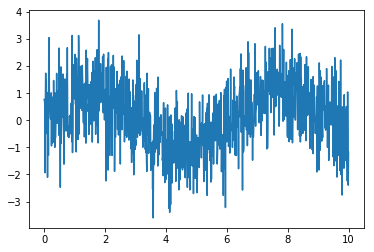

In [24]:
plt.plot(x,y)
plt.show()

Перемешаем выборку и разобьем её на тренировочную и контрольную части

In [15]:
train_idxes = np.random.choice(list(range(len(x))), 3 * len(x)//4)
test_idxes = np.array(range(len(x)))
test_idxes = np.delete(test_idxes, train_idxes)

X_Train = x[train_idxes]
Y_Train = y[train_idxes]

X_Test = x[test_idxes]
Y_Test = y[test_idxes]

Создадим граф:

In [16]:
x_ = tf.placeholder(name="input", shape=[None, 1], dtype=tf.float32)
y_ = tf.placeholder(name= "output", shape=[None, 1], dtype=tf.float32)
model_output = tf.Variable(tf.random_normal([1]), name='bias') + tf.Variable(tf.random_normal([1]), name='k') * x_

Нюанс - в плейсхолдере параметр формы (shape) содержит None. Размерность плейсхолдера означает, что плейсходер потребляет двумерные тензоры, но по одной из осей размер тензора не определен и может быть любым. Это сделано для того, чтобы пользователь мог передавать значения в граф сразу целыми батчами. Такие специфические размерности называют динамическими, TF рассчитывает действительную размерность связанных элементов во время выполнения графа.


Плейсхолдер для признака используется в формуле, а вот плейсхолдер для ответа я подставлю в функцию потерь $\frac{1}{n}\sum^{n}_{i=1}(y_i - \hat{y}_i)^2$:

In [17]:
loss = tf.reduce_mean(tf.pow(y_ - model_output, 2)) # функция потерь

В TF реализован десяток методов оптимизации. Мы будем использовать классический градиентный спуск, указав ему в параметрах скорость обучения.

Метод minimize создаст нам операцию, вычисление которой будет минимизировать функцию потерь.

In [18]:
gd = tf.train.GradientDescentOptimizer(0.0001) #оптимизатор
train_step = gd.minimize(loss)

Инициализация переменных - она необходима для дальнейших вычислений:

In [19]:
sess.run(tf.global_variables_initializer())

Первое выполнение сессией одновременно операций `train_step` и `loss` делает сразу и обучение, и оценку ошибки на обучающей выборке, т.е. собственно оценку того, как хорошо мы запомнили выборку. Второе выполнение сессии - подсчет потерь на тестовой выборке. В параметре `feed_dict` я передаю в граф значения для плейсхолдеров и делаю `reshape` для того, чтобы массивы данных совпадали по размерности. Там, где в плейсхолдере стояло значение `None`, можно передать любое число. Тензоры с такими неопределенными размерами называются динамическими, и вот тут я их использую, чтобы передавать в граф батчи с примерами для обучения.

In [20]:
n_epochs = 100
train_errors = []
test_errors = []
for i in tqdm.tqdm_notebook(range(n_epochs)):
    _, train_err = sess.run([train_step, loss ], feed_dict={x_:X_Train.reshape((len(X_Train),1)) , y_: Y_Train.reshape((len(Y_Train),1))})
    train_errors.append(train_err)
    test_errors.append(sess.run(loss, feed_dict={x_:X_Test.reshape((len(X_Test),1)) , y_: Y_Test.reshape((len(Y_Test),1))}))    

Widget Javascript not detected.  It may not be installed or enabled properly.


Получается вот такая динамика обучения:

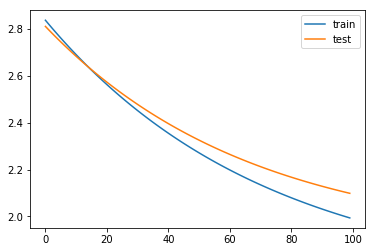

In [21]:
plt.plot(list(range(n_epochs)), train_errors, label = 'train' )
plt.plot(list(range(n_epochs)), test_errors, label='test') 
plt.legend()
plt.savefig('lin_reg.png')
plt.show()

В этом графе присутствуют вспомогательные переменные с градиентами и операции инициализации, они вынесены в отдельный блок.

<img src="https://habrastorage.org/files/87c/930/515/87c93051519f4eacb7b6f285768a1cf7.png" align='center'/>


А вот и результаты вычисления модели.


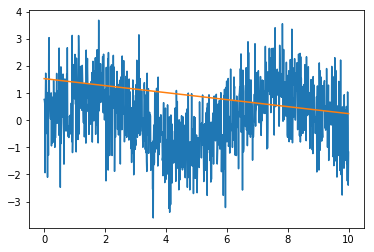

In [22]:
plt.plot(x, y)
plt.plot(x,sess.run(model_output, feed_dict={x_:x.reshape((len(x),1))}))
plt.savefig("lr_forward_pass.png")

Результат получился предсказуемым для такой простой линейной модели.

### Полиномиальная регрессия

Попробуем разнообразить регрессию полиномиальными признаками, регуляризацией и изменением скорости обучения модели.

In [25]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [26]:
order = 40
sess =tf.InteractiveSession()

создадим выборку заново:

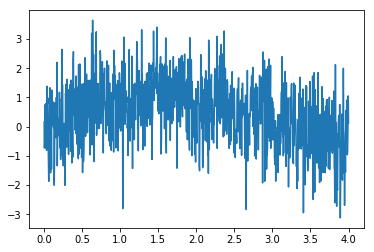

In [27]:
x = np.linspace(0,4, 1000)
y = np.sin(x) + np.random.normal(size=len(x))

plt.plot(x,y)
plt.savefig("data.png")
plt.show()

В генерации набора данных добавим некоторое количество степеней и нормируем признаки с помощью PolynomialFeatures и StandardScaler из библиотеки scikit-learn. Первый объект создаст нам полиномиальных признаков сколько захотим, а второй нормирует их.

In [28]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
poly_features = PolynomialFeatures(degree=order-1)
s = StandardScaler()
x_poly = s.fit_transform(poly_features.fit_transform(x.reshape(1000,1)))

Опять разобьем выборку:

In [29]:
shuffle_idxs =np.arange(len(x_poly))
np.random.shuffle(shuffle_idxs)

X_Train = x_poly[shuffle_idxs[:3*len(x)//4]]
Y_Train = y[shuffle_idxs[:3*len(x)//4]]

X_Test = x_poly[shuffle_idxs[3*len(x)//4:]]
Y_Test = y[shuffle_idxs[3*len(x)//4:]]

Для перехода к полиномиальной регрессии заменим всего несколько строк в графе вычислений.

In [30]:
x_ = tf.placeholder(name="input", shape=[None, order], dtype=tf.float32)
y_ = tf.placeholder(name= "output", shape=[None, 1], dtype=tf.float32)
w = tf.Variable(tf.random_normal([order,1]), name='weights')
model_output = tf.matmul(x_,w)

Фактически сейчас мы считаем $ model_{output} = \sum^{order}_{i=1}x^i w_i$. Очевидно, существует опасность переобучения модели на ровном месте, поэтому добавим регуляризационные штрафы на веса. Штрафы добавим к функции потерь (loss в примерах) в виде дополнительных слагаемых и получим почти что ElasticNet из sklearn. $$loss = \frac{1}{n}\sum^{n}_{i=1}(y_i - \hat{y}_i)^2+\alpha\sum{w}^2+\beta\sum|w|$$


In [31]:
loss = tf.reduce_mean(tf.pow(y_ - model_output, 2)) + 0.005* tf.nn.l2_loss(w) + 0.0005* tf.reduce_sum(tf.abs(w)) # функция потерь

Для самой популярной L2-регрессии существует отдельная функция ```l2_loss```, а вот отбор признаков с помощью L1 придется реализовать вручную, но у нас это будет среднее по всем абсолютным значениям весов.
Ради примера добавлю еще одно существенное изменение, которое коснется темпа обучения. Довольно часто при обучении тяжелых нейросетей это просто необходимая мера для того, чтобы избежать проблем с обучением и получить приемлемый результат. Очень простая идея - по мере обучения постепенно понижать параметр шага, избегая больших неприятностей.
Вместо константного темпа будем использовать экспоненциальное затухание, которое я взял прямиком из документации:

In [32]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                       100000, 0.96, staircase=True)

Внутри функции скрывается формула: 
$$learning\_rate_{decayed} = learning\_rate * decay\_rate^{\frac{global\_step}{decay\_steps}}$$
```decay_steps ``` в нашем примере присвоено значение 100000, ```decay_rate``` - 0.96.


Оптимизатор:

In [33]:
gd = tf.train.GradientDescentOptimizer(learning_rate)
train_step = gd.minimize(loss)
sess.run(tf.global_variables_initializer())

In [34]:
train_errors = []
test_errors = []
n_epochs = 1000
for i in tqdm.tqdm_notebook(range(n_epochs)): # 1000
    _, train_err = sess.run([train_step, loss ], feed_dict={x_:X_Train, y_: Y_Train.reshape(len(Y_Train),1)})
    train_errors.append(train_err)
    test_errors.append(sess.run(loss, feed_dict={x_:X_Test, y_: Y_Test.reshape((len(Y_Test),1))}))


Widget Javascript not detected.  It may not be installed or enabled properly.


Динамика обучения:

[21.531517, 6.3873048, 4.8107047, 4.3594384, 4.0414281, 3.7719882, 3.5391219, 3.3373287, 3.1622555, 3.0101902]
[6.1812997, 4.6432276, 4.2074599, 3.9160933, 3.6744576, 3.4673719, 3.2888689, 3.1347499, 3.0015531, 2.8863218]


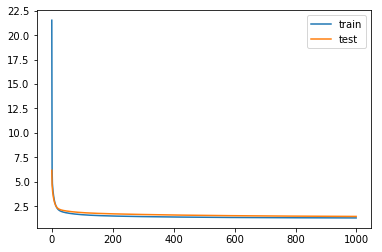

In [35]:
plt.plot(list(range(n_epochs)), train_errors, label = 'train' )
plt.plot(list(range(n_epochs)), test_errors, label='test') 
plt.legend()
plt.savefig('poly_reg_train.png')
print(train_errors[:10])
print(test_errors[:10])


Помимо экспоненциального затухания есть и другие функции, которые позволяют снижать скорость обучения, и конечно ничто не мешает создать еще одну функцию под свои нужды.          

Сама модель после обучения и разнообразных подборов параметров будет выглядеть как-то так:

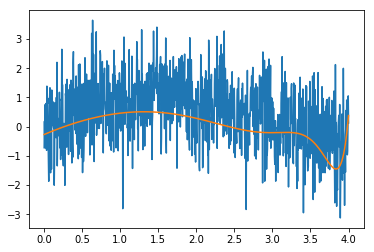

In [36]:
plt.plot(x, y)
plt.plot(x,sess.run(model_output, feed_dict={x_:x_poly.reshape((len(x),order))}))
plt.savefig("poly_forward_pass.png")

Для получения этого результата я изменял коэффициенты при регуляризации и скорости обучения. Перебор значений констант в формуле потерь - отличный способ увидеть своими глазами эффект работы регуляризаторов, крайне рекомендую поиграть с настройками.

## Сохранение и загрузка графов

Мы получили модель и было бы неплохо её сохранить. В TF всё достаточно просто - в API есть специальный объект-сериализатор, который делает две вещи:  

1. Сохраняет текущий граф, его состояние и значения переменных в файл;
2. Читает всё то же самое из файла.

Вот всё что нужно  - это создать этот объект:

In [37]:
saver = tf.train.Saver()

Сохранение состояния текущей сессии производится с помощью метода `save`.
```
saver.save(sess, "model.ckpt")
```

Уже как-то принято, что сохраненные состояния модели называют чекпойнтами, отсюда название папок и расширения файлов. Восстановление производится с помощью метода `restore`:
```
ckpt = tf.train.get_checkpoint_state('.')
if ckpt and ckpt.model_checkpoint_path:
    print(ckpt.model_checkpoint_path)
    saver.restore(session, ckpt.model_checkpoint_path)
```

Сначала с помощью специальной функции получаем состояние чекпойнта (если вдруг в целевой директории нет сохраненной модели, функция вернет `None`). По умолчанию функция ищет файл `checkpoint`, но это поведение можно изменить с помощью параметра. После этого `restore` восстанавливает состояние графа.

## Tensorboard

Крайне полезная система в составе TF - web-dashboard, который позволяет собирать статистику из дампов и логов и наблюдать, что же всё-таки происходит во время вычислений. Крайне удобно то, что дашборд работает на веб-сервере и можно, например, запустив tensorboard на удаленной машине в облаке, наблюдать происходящее у себя в окне браузера.

Tensorboard умеет:

1. Рисовать граф вычислений.
Граф вычислений стоит посмотреть хотя бы для самопроверки, чтобы убедиться в том, что собралось и считается именно то, что планировалось, и при кодировании не допущено ошибок.  
2. Показывать статистику по переменным.
Можно собирать вообще любую статистику.
3. Есть средство для анализа многомерных данных (например, эмбеддингов). 
Для этого в дашборде встроены PCA и t-SNE, с которыми можно попробовать рассмотреть данные в 2 и 3 измерениях.
4. Гистограммы.
Можно строить гистограммы распределений выходов слоев сетей и поведения переменных.

Обратная сторона медали - чтобы статистика попадала в дашборд, её нужно сохранять в логи (в формате protobuf) с помощью специального API. API не очень сложный, сгруппирован в ```tf.summary```. Для сбора статистики нужно будет отдельно зарегистрировать  интересующие переменные с помощью специальных функций и потом отдельно сохранить всё в лог.

Еще при использовании Tensorboard важно также не забывать про параметр ```name``` у переменных. Имя, которое будет присвоено переменной, потом будет использоваться для отрисовки графа, выбора в пользовательском интерфейсе дашборда, в общем, везде. Для небольших графов это не критично, но с ростом сложности задачи могут возникнуть проблемы с пониманием происходящего. 

Есть несколько типов функций, которые сохраняют данные переменных различным образом:

```python
tf.summary.histogram("layer_output", w_h)
```

Данная функция позволит собрать гистограмму для выхода слоя и примерно оценить динамику изменений при обучении. Функция ``` tf.summary.scalar("accuracy", learning_rate)``` будет сохранять число. Еще можно сохранять аудио и картинки.

Для сохранения логов нужно чуть больше: сначала нужно создать FileWriter для записи файла.

```python
writer = tf.summary.FileWriter("./logs/nn_logs", sess.graph) # for 1.0
merged = tf.summary.merge_all()
```

И объединить всю статистику в одном объекте.

Теперь нужно вот этот объект `merged` передать на выполнение в сессию и потом с помощью метода ```FileWriter``` добавить новые данные, полученные от сессии.

```python
summary, op_result = sess.run([merged, op], feed_dict={X: X_train,  Y: y_train,
                                          p_keep_input: 1.0, p_keep_hidden: 1.0})  
        writer.add_summary(summary, i)
```

Впрочем, для простого сохранения графа достаточно вот такого кода:

```python
merged = tf.summary.merge_all(key='summaries')
if not os.path.exists('tensorboard_logs/'):
    os.makedirs('tensorboard_logs/')
my_writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)
```  

И нюанс: по умолчанию Tensorboard локально доступен по адресу 127.0.**1**.1:6006. Надеюсь, сохранил читателям несколько секунд времени и нейронов этим замечанием.


## Многослойный перцептрон

Разберем каноничный пример с запоминанием функции xor, которую линейная модель не может усвоить из-за невозможности линейного разделения пространства признаков.

<img src="https://habrastorage.org/files/dc9/f2b/3b2/dc9f2b3b24a34d8684eca18fdbe5d449.png" align='center'/>

Многослойные сети усваивают функцию из-за того, что делают неявное преобразование пространства признаков в разделимое или же (в зависимости от реализации) делают нелинейное разбиение этого пространства. Мы реализуем первый вариант - создадим двухслойный перцептрон с нелинейной активацией слоев. Первый слой будет делать нелинейное преобразование, а второй слой - это практически линейная регрессия, которая работает на преобразованном пространстве признаков.

В качестве элемента нелинейности будем использовать функцию <a href="https://en.wikipedia.org/wiki/Rectifier_(neural_networks)">relu</a>.

In [37]:
ops.reset_default_graph()
sess =tf.Session()

Определим структуру сети:

In [38]:
x_ = tf.placeholder(name="input", shape=[None, 2], dtype=tf.float32)
y_ = tf.placeholder(name= "output", shape=[None, 1], dtype=tf.float32)

hidden_neurons = 15
w1 = tf.Variable(tf.random_uniform(shape=[2,hidden_neurons ]))
b1 = tf.Variable(tf.constant(value=0.0, shape=[hidden_neurons ], dtype=tf.float32))
layer1 = tf.nn.relu(tf.add(tf.matmul(x_, w1), b1))

w2 = tf.Variable(tf.random_uniform(shape=[hidden_neurons ,1]))
b2 =  tf.Variable(tf.constant(value=0.0, shape=[1], dtype=tf.float32))

nn_output = tf.nn.relu(tf.add(tf.matmul(layer1, w2), b2))

В отличие от keras и других более высокоуровневых библиотек, TF, подобно Theano предполагает детальное определение каждого слоя как совокупности некоторых арифметических операций. Это верно не для всех видов слоёв, например, сверточные и dropout-слои определяются одной функцией, в то время как обычный полносвязный слой представляет собой объявление не только переменных для весов и сдвигов, но и самих операций (перемножение весов с выходом предыдущего слоя, добавление сдвига, применение функции активации).

Разумеется, довольно часто всё это оборачивается в подобную функцию:

```python
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))
```

При этом по моему собственному опыту объявление и инициализацию переменных удобнее оставлять снаружи: иногда требуется использовать их еще где-нибудь внутри графа (типичный пример - сиамские нейронные сети с общими весами) или же просто иметь доступ для простого логирования в файл и вывода текущих значений, а tensorboard по каким-то причинам пользоваться не хочется.


Используем элементарную функцию потерь:

In [39]:
gd = tf.train.GradientDescentOptimizer(0.001)
loss =  tf.reduce_mean(tf.square(nn_output- y_))
train_step = gd.minimize(loss)

In [40]:
init = tf.global_variables_initializer()
sess.run(init)

и обучим:

In [41]:
x = np.array([[0,0],[1,0],[0,1],[1,1]])
y = np.array([[0],[1],[1],[0]])
for _ in tqdm.tqdm_notebook(range(20000)):
    sess.run(train_step, feed_dict={x_:x, y_:y})

Получившийся граф:
<img src="https://habrastorage.org/files/76e/2e4/185/76e2e41856fb443bab060434e0f9aec2.png" align='center'/>
В сравнении с регрессией практически ничего не изменилось: тот же процесс обучения, та же функция потерь. Единственная часть кода, которая сильно изменилась - это код построения вычислительного графа. Дошло до того, что у меня накопился набор скриптов под конкретные задачи, в которых я меняю только подачу данных и граф вычислений.
Конечно, в данном примере нет проверки на отложенной выборке. Убедиться в правильности работы сети можно с помощью вычисления выхода нейронной сети в графе:

In [42]:
sess.run(nn_output, feed_dict={x_:x})

array([[ 0.00596322],
       [ 0.9970997 ],
       [ 0.9980647 ],
       [ 0.00205923]], dtype=float32)

На ноутбуке пятилетней давности весь код отрабатывает за 5 секунд.

Конечно, в случае более сложных моделей добавляется валидация на отложенной выборке и слежение за качеством по мере обучения и встроенные в TF методы подачи данных в граф.

## Управление ресурсами

Довольно часто мир бывает несправедлив, и задача может не помещаться полностью в одно устройство. Или же менеджмент купил всего одну Tesla, и разработчики периодически вступают в конфликты из-за занятой карточки. В TF на такие случаи есть механизмы управления вычислениями. Внутри фреймворка устройства обозначаются как «/cpu:0», «/gpu:0» и т.д. Самое простое - можно указывать, где конкретно будет «жить» та или иная переменная:

```python
with tf.device('/cpu:0'):
    a = ...    
```

В этом примере переменная ```а``` отправится на процессор.

Еще можно передать в сессию конфигурационный объект, с помощью которого можно изменять проведение вычислений графа. Выглядит это примерно так:

```python
cfg = tf.ConfigProto()
sess = tf.Session(config=cfg)
```

В конфиге первым делом можно включить параметр ```log_device_placement```, чтобы понимать, в какое вычислительное устройство отправилось вычисление той или иной части графа.

Допустим, в команде разработчиков можно договориться об ограничении потребления памяти GPU. Сделать это можно с помощью такого кода:

```python
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
```

В такой конфигурации сессия не будет потреблять более четверти памяти GPU, а это значит, что можно одновременно запустить расчеты еще нескольких моделей, а еще можно запустить модель считаться на CPU, но проще всего включить параметр ```allow_soft_placement```, чтобы TF решал эти проблемы сам. Для этой части API документация еще довольно фрагментарна и некоторые ссылки ведут сразу на гитхаб в исходники конфигурационных классов. Часть свойств там отмечена как устаревшая, другая часть - как экспериментальная, поэтому тут будет нужна аккуратность.

## Заключение

TF буквально за год-полтора разросся настолько, что впору делать отдельные обзоры о применении сверточных и рекуррентных сетей, обучения с подкреплением и о применении фреймворка к различным задачам. В этом кратком обзоре не затронуты темы структур для чтения данных, свертки, разнообразные методы оптимизации и высокоуровневые библиотеки-обертки. Продолжить знакомство можно, попробовав для начала «поиграть» с настройками обучения и разобравшись с различными оптимизаторами. Ну и конечно попробовать TF в соревнованиях на Kaggle!

Автор выражает благодарность @sovcharenko, @Ferres и @bauchgefuehl за помощь в подготовке текста.